# Apprentissage supervisé : régression logistique, validation croisée et reconnaissance de visages

# Table of contents
1. [Régression logistique](#part1)
    - [Sur et sous-apprentissage](#part1sec1)
    - [Validation croisée](#part1sec2)
    - [Application à la reconnaissance de visages](#part1sec3)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
from scipy.stats import multivariate_normal

def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

def gaussian_sample(mu=[0, 0], sigma1=1., sigma2=1., theta=0., n=50):
    cov = covariance(sigma1, sigma2, theta)
    x = multivariate_normal.rvs(mean=mu, cov=cov, size=n)
    return x

def plot_frontiere(clfs, data=None, data_labels=None, label=None, num=500, figure=True):
    """
        Plot the frontiere fun(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clfs: classifier or list of classifiers
            data: input data (X)
            data_labels: data labels (y)
            label: classifier labels as a list
            num: discretization parameter
            figure: create a new figure
    """
    if not hasattr(clfs, '__iter__'):
        clfs = [clfs]
    if label is not None and not hasattr(label, '__iter__'):
        label = [label]
    for i in range(len(clfs)):
        if not hasattr(clfs[i], 'decision_function'):
            temp = lambda x: None
            temp.decision_function = clfs[i]
            clfs[i] = temp
        
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    
    if figure:
        plt.figure(figsize=(7, 7))
#     plt.scatter(*data.T, c=data_labels, cmap='plasma')
    for icl, cl in enumerate(np.unique(data_labels)):
        plt.scatter(*data[data_labels==cl].T, label=f'Class {cl}')
        
    for i, clf in enumerate(clfs):
        z = clf.decision_function(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
        cs = plt.contour(x, y, z, [0], colors='r')
        if label is not None:
            cs.levels = [label[i]]
            plt.gca().clabel(cs)
    if figure:
        plt.axis('image')
    minx, miny = data[:, 0].min(), data[:, 1].min()
    diffx, diffy = data[:, 0].max() - minx, data[:, 1].max() - miny
    plt.axis([minx - 0.1*diffx, minx + 1.1*diffx, miny - 0.1*diffy, miny + 1.1*diffy])
    plt.legend(loc="best")

# Régression logistique <a id="part1"></a>


In [3]:
# Dataset
X1 = gaussian_sample(mu=[0, 0])  # First class
X2 = gaussian_sample(mu=[5, 3], n=25)  # Second class
X3 = gaussian_sample(mu=[8, 9], n=25)  # Second class

X = np.r_[X1, X2, X3]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

<div class="alert alert-block alert-info">
Comparer les frontières obtenues par analyse linéaire discriminante et régression logistique pour des classes non-gaussiennes.  
<!-- <br> -->
</div>

In [ ]:
# Answer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# Fit the model
# Todo

# End todo

# Logistic regression with big penalty parameter => unregularized
lr = LogisticRegression(C=1e8)
# Fit the model
# Todo

# End todo

plot_frontiere([lda, lr], X, Y, label=["LDA", "Logistic regression"])

In [5]:
# Dataset
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3], n=49)
X3 = gaussian_sample(mu=[20, 20], n=1).reshape(1, -1)

X = np.r_[X1, X2, X3]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

<div class="alert alert-block alert-info">
Faire de même dans cette situation (présence d'un point levier).    
<!-- <br> -->
</div>

In [ ]:
# Answer

## Sur et sous-apprentissage <a id="part1sec1"></a>


In [7]:
def frontiere(x):
    w = np.array([1, 1])
    w = w / np.linalg.norm(w)
    w_orth = np.array([-w[1], w[0]])
    return 5*(x@w_orth - 0.5*np.sin(2*np.pi * x@w))
    
n = 200
X = np.random.rand(n, 2)
p = 1 / (1 + np.exp(-frontiere(X)))
y = 2*np.random.binomial(1, p) - 1

<div class="alert alert-block alert-info">
    Commençons par afficher les données et la frontière qui les a générées.
<!-- <br> -->
</div>

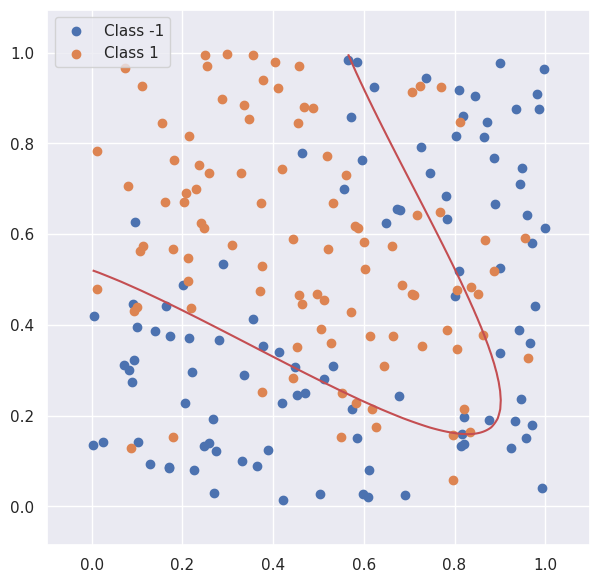

In [8]:
# Plot
plot_frontiere(frontiere, X, y)

<div class="alert alert-block alert-info">
    Afficher la frontière obtenue par régression logistique.
<!-- <br> -->
</div>

In [ ]:
# Answer
from sklearn.linear_model import LogisticRegression

# Build and fit the model
# Todo

# End todo

plot_frontiere(lr.decision_function, X, y)

<div class="alert alert-block alert-info">

Faire de même avec une transformation polynomiale des données (on pourra utiliser `PolynomialFeatures`).
Mettre en évidence le sur-apprentissage.

<!-- <br> -->
</div>

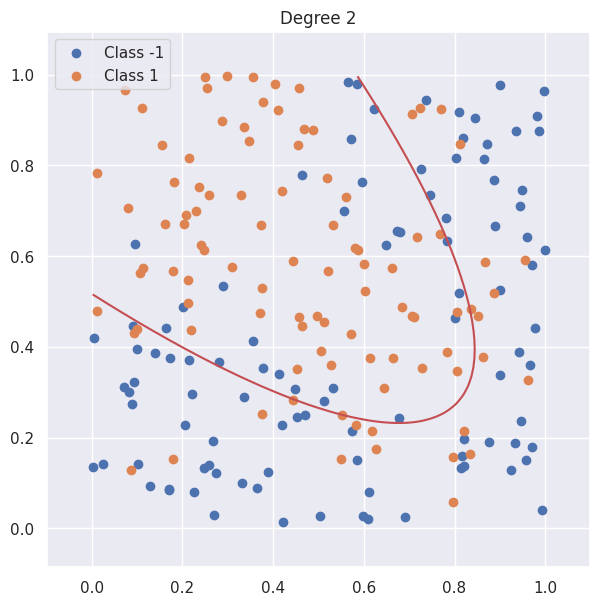

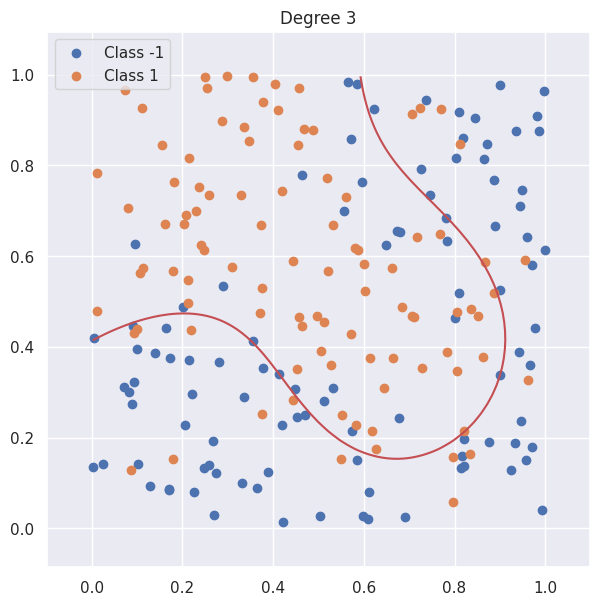

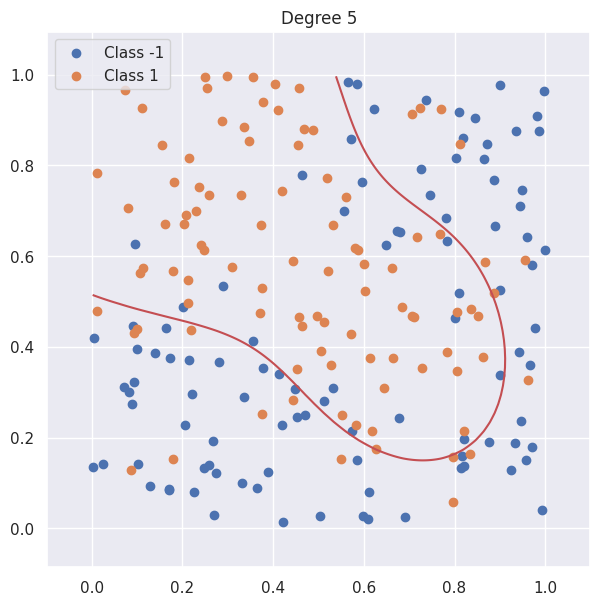

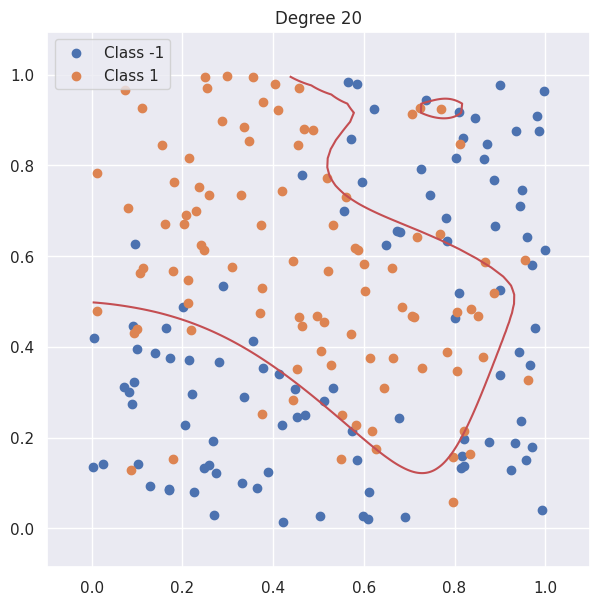

In [10]:
# Plot
from sklearn.preprocessing import PolynomialFeatures

for degree in [2, 3, 5, 20]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lr.fit(poly.fit_transform(X), y)
    plot_frontiere(lambda x: lr.decision_function(poly.transform(x)), X, y)
    plt.title(f'Degree {degree}')

## Validation croisée <a id="part1sec2"></a>


<div class="alert alert-block alert-info">
    
Sélectionner par validation croisée (on utilisera `GridSearchCV`) le degré et la présence (ou non) d'intéractions dans la redescription polynomiale.

<!-- <br> -->
</div>

In [ ]:
# Answer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

poly_lr = Pipeline([('poly', PolynomialFeatures(include_bias=False)), ('lr', LogisticRegression(C=1e2))])
# poly_lr.get_params()

poly_lr_cv = GridSearchCV(poly_lr, dict(poly__degree=[1, 2, 3], poly__interaction_only=[False, True]),
                          cv=3, n_jobs=-1, verbose=True)
# Run the grid search
# Todo

# End todo

In [12]:
# Results
print("Best parameters:", poly_lr_cv.best_params_)

print('\nMean test score for each pair of parameters:')
for pair, score in zip(poly_lr_cv.cv_results_['params'], poly_lr_cv.cv_results_['mean_test_score']):
    print(pair, ':', score)
# poly_lr_cv.cv_results_

Best parameters: {'poly__degree': 3, 'poly__interaction_only': False}

Mean test score for each pair of parameters:
{'poly__degree': 1, 'poly__interaction_only': False} : 0.6051560379918589
{'poly__degree': 1, 'poly__interaction_only': True} : 0.6051560379918589
{'poly__degree': 2, 'poly__interaction_only': False} : 0.7451379466304839
{'poly__degree': 2, 'poly__interaction_only': True} : 0.6750339213025779
{'poly__degree': 3, 'poly__interaction_only': False} : 0.7602140811096035
{'poly__degree': 3, 'poly__interaction_only': True} : 0.6750339213025779


## Application à la reconnaissance de visages <a id="part1sec3"></a>


In [13]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(data_home='~/data/', resize=0.4, min_faces_per_person=70,
                             color=True, funneled=False, slice_=None)

In [14]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [15]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [16]:
n, h, w, _ = lfw_people.images.shape
print(f"Images: {n}\nHeight: {h}\nWidth: {w}")

Images: 1288
Height: 100
Width: 100


In [17]:
ind = np.where(np.logical_or(lfw_people.target == list(lfw_people.target_names).index('Hugo Chavez'),
                            lfw_people.target == list(lfw_people.target_names).index('Ariel Sharon')))[0]
images = lfw_people.images[ind]
X = np.mean(images, axis=3).reshape(-1, h*w)
y = lfw_people.target[ind]

In [18]:
def show_image(i, label=None):
    plt.imshow(images[i])
    plt.axis('image')
    plt.grid(False)
    plt.title(f'{lfw_people.target_names[y[i]]}' +
              (f'\n (pred: {lfw_people.target_names[label]})' if label is not None else ''))

<div class="alert alert-block alert-info">

Afficher quelques images du jeu de données.

<!-- <br> -->
</div>

In [ ]:
# Answer
for i, im in enumerate(np.random.permutation(X.shape[0])[:4]):
    plt.subplot(2, 2, i+1)
    # Show image with show_image
    # Todo

    # End todo

<div class="alert alert-block alert-info">

Séparer le jeu de données en deux ensembles et réaliser des prédictions par régression logistique.

<!-- <br> -->
</div>

In [ ]:
# Answer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Fit the model and store the predictions in y_pred
# Todo

# End todo

print(f"Class proportions: {np.mean(y==y.min()), np.mean(y==y.max())}")
print(f"Test score: {lr.score(X_test, y_test)}")

<div class="alert alert-block alert-info">

Afficher quelques images du jeu de données et leurs prédictions.

<!-- <br> -->
</div>

In [ ]:
# Answer
plt.figure(figsize=(10, 10))
for i, im in enumerate(np.random.permutation(X.shape[0])[:16]):
    plt.subplot(4, 4, i+1)
    # Show image and prediction with show_image
    # Todo

    # End todo
plt.tight_layout()

<div class="alert alert-block alert-info">

Afficher, sous forme d'image, les coefficients utilisés par la régression logistique.

<!-- <br> -->
</div>

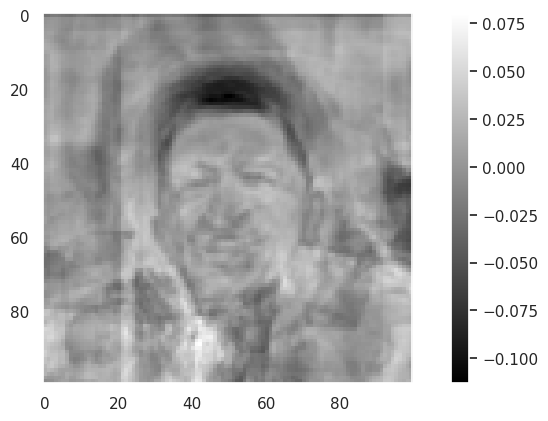

In [22]:
# Coefficients
plt.imshow(lr.coef_.reshape(h, w), cmap='gray')
plt.colorbar()
plt.axis('image')
plt.grid(False)